# Logistic Regression with colour + greyscale + image enhancement

Added different image enhancements to the model in step 4, ie 10 features
+ varying the clip limit of the Adaptive Histogram Equalisation to find optimal value

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from mask_to_submission import *

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from skimage import data, img_as_float
from skimage import exposure
from skimage.morphology import disk
from skimage.filters.rank import enhance_contrast
from skimage.color import rgb2gray
from skimage.filters.rank import autolevel

import pandas as pd

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

print("Processing " + str(n) + " enhanced images")


gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Processing 100 enhanced images
Loading 100 images
satImage_001.png


In [4]:
# Extract patches from input images
patch_size = 38 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [5]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

def extract_features_all(img, img_e):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat_m1 = np.mean(img)
    feat_v1 = np.var(img)
    f = np.append(feat_v, feat_m)
    f1 = np.append(feat_v1, feat_m1)
    feature = np.append(f, f1)
    
    feat_m2 = np.mean(img_e)
    feat_v2 = np.var(img_e)
    f2 = np.append(feat_v2, feat_m2)
    
    feat = np.append(feature, f2)

    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([extract_features_all(img_patches[i],img_patches_e[i]) for i in range(len(img_patches))])
    return X

In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def compute_best_f1_for_clipping(limit):
    
    imgs_e = [exposure.equalize_adapthist(imgs[i], clip_limit=limit) for i in range(n)]
    img_patches_e = [img_crop(imgs_e[i], patch_size, patch_size) for i in range(n)]
    img_patches_e = np.asarray([img_patches_e[i][j] for i in range(len(img_patches_e)) for j in range(len(img_patches_e[i]))])
    
    X = np.asarray([ extract_features_all(img_patches[i], img_patches_e[i]) for i in range(len(img_patches))])
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    
    #Train-Test split
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=42)
    
    # we create an instance of the classifier and fit the data
    classifier = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    classifier.fit(X_train, y_train)

    #Train-Test split
    k = 40
    f1 = cross_val_score(classifier, X, Y, cv=k, scoring="f1")
    
    return f1.mean()



In [7]:
clip = []
scores = []
for i in range(0, 1000, 20):
    f1 = compute_best_f1_for_clipping(i/1000)
    clip.append(i)
    scores.append(f1)

C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarnin

C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\jamie\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


0.5775738511206872


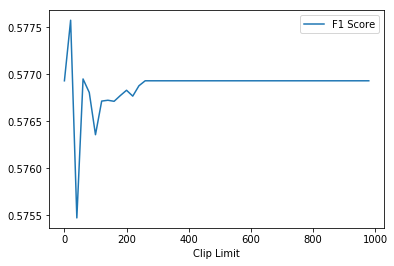

In [8]:
d = {'Clip Limit': clip, 'F1 Score': scores}
df = pd.DataFrame(d)
df.plot(x='Clip Limit')
print(max(scores))